<a href="https://colab.research.google.com/github/SergeyHSE/ALSalgorithm.github.io/blob/main/ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this work, we will find similar movies and users using the ALS algorithm,
implement the calculation of the NDCG metric, and investigate
the effect of the dimensionality of hidden representations on the performance of the algorithm.

Dataset = MovieLens

In [1]:
import zipfile
from collections import defaultdict, Counter
import datetime
from scipy import linalg
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2023-12-01 12:41:37--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  17.5MB/s    in 0.3s    

2023-12-01 12:41:37 (17.5 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [3]:
#Let's unpack the data and see how it's organized.

with zipfile.ZipFile("ml-1m.zip", "r") as z:
    print("files in archive")
    print(z.namelist())
    print("movies")
    with z.open("ml-1m/movies.dat") as m:
        print(str(m.readline()).split("::"))
    print("users")
    with z.open("ml-1m/users.dat") as m:
        print(str(m.readline()).split("::"))
    print("ratings")
    with z.open("ml-1m/ratings.dat") as m:
        print(str(m.readline()).split("::"))

files in archive
['ml-1m/', 'ml-1m/movies.dat', 'ml-1m/ratings.dat', 'ml-1m/README', 'ml-1m/users.dat']
movies
['b"1', 'Toy Story (1995)', 'Animation|Children\'s|Comedy\\n"']
users
["b'1", 'F', '1', '10', "48067\\n'"]
ratings
["b'1", '1193', '5', "978300760\\n'"]


In [ ]:
with zipfile.ZipFile("ml-1m.zip", 'r') as zip:
    file_content = zip.read('ml-1m/README')
    decoded_content = file_content.decode('utf-8')  # Decode the content assuming it's in UTF-8

    # Replace single newlines with a special token
    content_with_token = decoded_content.replace('\n', '||NEWLINE||')

    # Replace double newlines with spaces
    formatted_content = ' '.join(para.strip() for para in content_with_token.split('\n\n'))

    # Restore single newlines
    formatted_content = formatted_content.replace('||NEWLINE||', '\n')

    print(formatted_content)

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

We can see that the archive contains information about movies.
This is the movieId of the movie, title and genre.
About users we know userId, gender (F, M), age, coded employment information and zip-code.
And the rating information:
userId, movieId, rating and the moment in time when the rating was made.
Let's read the data.

In [4]:
# read data
movies = {} # id
users = {} # id
ratings = defaultdict(list) # user-id

with zipfile.ZipFile("ml-1m.zip", "r") as z:
    # parse movies
    with z.open("ml-1m/movies.dat") as m:
        for line in m:
            MovieID, Title, Genres = line.decode('iso-8859-1').strip().split("::")
            MovieID = int(MovieID)
            Genres = Genres.split("|")
            movies[MovieID] = {"Title": Title, "Genres": Genres}

    # parse users
    with z.open("ml-1m/users.dat") as m:
        fields = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
        for line in m:
            row = list(zip(fields, line.decode('iso-8859-1').strip().split("::")))
            data = dict(row[1:])
            data["Occupation"] = int(data["Occupation"])
            users[int(row[0][1])] = data

    # parse ratings
    with z.open("ml-1m/ratings.dat") as m:
        for line in m:
            UserID, MovieID, Rating, Timestamp = line.decode('iso-8859-1').strip().split("::")
            UserID = int(UserID)
            MovieID = int(MovieID)
            Rating = int(Rating)
            Timestamp = int(Timestamp)
            ratings[UserID].append((MovieID, Rating, datetime.datetime.fromtimestamp(Timestamp)))

In [5]:
len(users), len(ratings), len(movies)

(6040, 6040, 3883)

Now let's split the data into training and test samples
We will split the ratings by time.
First, let's find the date on which 80% of the ratings were set in the dataset.
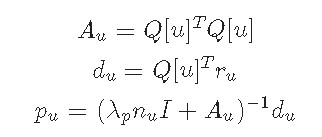And all the ratings that were before will go to train, and the rest to test.

In [6]:
times = []
for user_ratings in ratings.values():
    times.extend([x[2] for x in user_ratings])
times = sorted(times)

threshold_time = times[int(0.8 * len(times))]
threshold_time

datetime.datetime(2000, 12, 2, 14, 52, 18)

In [7]:
train = []
test = []

for user_id, user_ratings in ratings.items():
    train.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] <= threshold_time)
    test.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] > threshold_time)
print("ratings in train:", len(train))
print("ratings in test:", len(test))

ratings in train: 800168
ratings in test: 200041


In [8]:
train_by_user = defaultdict(list)
test_by_user = defaultdict(list)
for u, i, r in train:
    train_by_user[u].append((i, r))
for u, i, r in test:
    test_by_user[u].append((i, r))

train_by_item = defaultdict(list)
for u, i, r in train:
    train_by_item[i].append((u, r))

In [9]:
#Let's count the number of users and movies

n_users = max([e[0] for e in train]) + 1
n_items = max([e[1] for e in train]) + 1
n_users, n_items

(6041, 3953)

In [10]:
np.random.seed(0)
LATENT_SIZE = 10
N_ITER = 20

# regularizers
lambda_p = 0.2
lambda_q = 0.001

# latent representations
p = 0.1 * np.random.random((n_users, LATENT_SIZE))
q = 0.1 * np.random.random((n_items, LATENT_SIZE))


In this approach, the score $r_{ui}$ of user $u$ given to movie $i$,

is sought as the scalar product of vectors $p_u$ and $q_i$ in some space $\mathbb{R}^K$ of latent features:

$$
	\hat{r}_{ui} = p_u^T q_i
$$


In other words, the model finds a feature space in which we describe both movies and users and in which the rating is a measure of the closeness between movies and users.

To tune the model, we will minimize the following error:
	$$
	\sum_{(u, i, r_{ui})} (r_{ui} - p_u^T q_i)^2 + \lambda_{p} p_u^T p_u + \lambda_{q} q_i^T q_i,
	$$
	where the summation is over all triples $(u, i, r_{ui})$ of the sample, the summands with $\lambda_{p}$ and $\lambda_{q}$ are added for regularization.

Now let us make a matrix $P$ from vectors $p_u$ and a matrix $Q$ from vectors $q_i$. By matrix $Q[u] \in \mathbb{R}^{n_u \times K}$ we denote the submatrix of matrix $Q$ only for goods evaluated by user $u$, where $n_u$ is the number of evaluations of user $u$.

The reconfiguration step $p_u$ for a fixed matrix $Q$ reduces to the ridge regression setup and looks like this:
	$$
	A_u = Q[u]^T Q[u] \\\\
	d_u = Q[u]^T r_u \\\
	p_u = (\lambda_p n_u I + A_u)^{-1} d_u
	$$